In [1]:
#导库
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
from torchvision import datasets
from torch.optim import lr_scheduler
import math

In [2]:
#定义学习率衰减是所需要的训练函数，因为d2l库中提供的train_ch3函数只能有六个参数，所以会导致在导入学习率调度器的过程中遇到困难
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3) # train_loss,train_acc,num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l = torch.sum(l)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
                
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

In [3]:
#导入数据
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [4]:
#网络结构
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256,128),
                    nn.ReLU(),
                    nn.Linear(128, 10))
#初始化
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
#训练参数
batch_size, lr, num_epochs = 256, 0.1, 10
#softmax+交叉熵损失
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

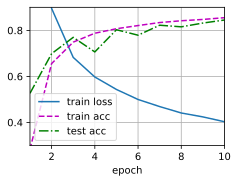

In [6]:
#多层感知机的训练
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

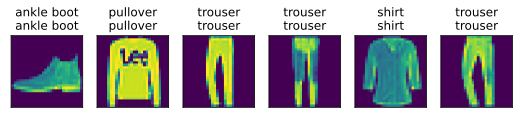

In [7]:
#预测
d2l.predict_ch3(net, test_iter)

In [8]:
#调整输入参数方便后续
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [9]:
def get_fashion_mnist_data(batch_size=256, n=1500):
    # 定义图像预处理操作，将图像转换为张量，并进行标准化
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # 加载 Fashion MNIST 数据集
    data = datasets.FashionMNIST(root='E:/Deeplearning/data/FashionMNIST/raw', train=True, transform=transform, download=True)

    # 假设你想使用前 `n` 个样本
    data = torch.utils.data.Subset(data, list(range(n)))

    # 创建 DataLoader 对象，用于批量加载数据
    data_iter = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=4)

    return data_iter  # 假设图像是 28x28 的灰度图像

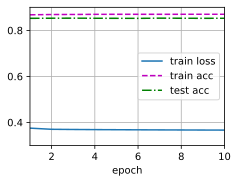

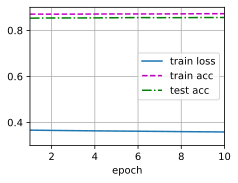

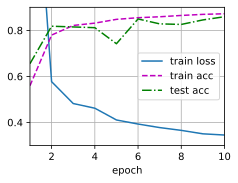

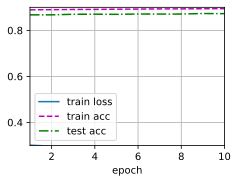

In [10]:
#SGD优化函数
def train_sgd(lr, batch_size, num_epochs):
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    return d2l.train_ch3(net, train_iter=train_iter, test_iter=test_iter, loss=loss, num_epochs=num_epochs, updater=optimizer)
#调整学习率及批次
gd_res = train_sgd(0.001, 1500, 10)
sgd_res = train_sgd(0.005, 1,10)
mini1_res = train_sgd(.4, 100,10)
mini2_res = train_sgd(.05, 10,10)

train loss nan, train acc 0.100, test acc 0.100


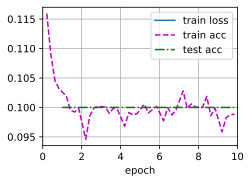

In [11]:
#固定学习率
lr, num_epochs = 0.3, 10
trainer = torch.optim.SGD(net.parameters(), lr=lr)
device='cpu'
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [12]:
#指数衰减
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr
        
    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)


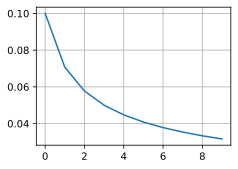

In [13]:
scheduler = SquareRootScheduler(lr=0.1)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss nan, train acc 0.100, test acc 0.100


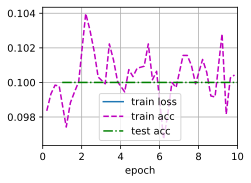

In [14]:
trainer = torch.optim.SGD(net.parameters(), lr)
device='cpu'
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,scheduler)

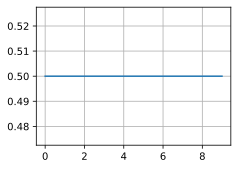

In [15]:
#多项式衰减
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler2 = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler2.get_last_lr()[0]
    trainer.step()
    scheduler2.step()
    return lr
d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler2)
                                  for t in range(num_epochs)])


train loss nan, train acc 0.100, test acc 0.100


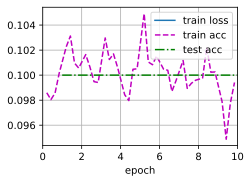

In [16]:
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
    scheduler2)

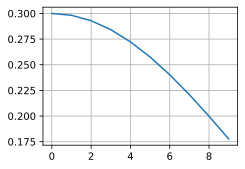

In [21]:
#余弦衰减
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
                warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
        
    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                      * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase
    
    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler3 = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler3(t) for t in range(num_epochs)])

train loss nan, train acc 0.100, test acc 0.100


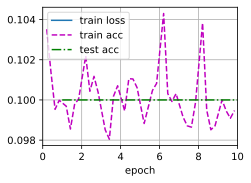

In [22]:
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler3)

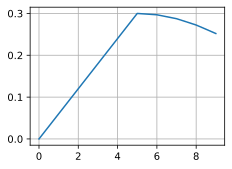

In [23]:
#预热
scheduler4 = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler4(t) for t in range(num_epochs)])

train loss nan, train acc 0.100, test acc 0.100


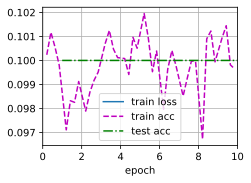

In [24]:
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler4)